Get the word2vec package:

In [4]:
!git clone https://github.com/tmikolov/word2vec.git
%cd word2vec/
!make

/bin/sh: 1: git: not found
[Errno 2] No such file or directory: 'word2vec/'
/home/miri-o/Documents
make: *** No targets specified and no makefile found.  Stop.


Get the default corpus:

In [2]:
!wget http://mattmahoney.net/dc/text8.zip -O text8.gz
!gzip -d text8.gz -f

--2018-03-06 13:36:54--  http://mattmahoney.net/dc/text8.zip
Resolving mattmahoney.net (mattmahoney.net)... 67.195.197.75
Connecting to mattmahoney.net (mattmahoney.net)|67.195.197.75|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31344016 (30M) [application/zip]
Saving to: ‘text8.gz’

text8.gz            100%[===================>]  29.89M   430KB/s    in 67s     

2018-03-06 13:38:01 (457 KB/s) - ‘text8.gz’ saved [31344016/31344016]



Train a basic word2vec model:

parameters:
-train: training corpus
-output: name of output file
-cbow: 1 - use cbow, 0 - use skip-gram
-size: the dimensions of the vectors
-window: the window size
-negative: number of negative words to sample (for negative sampling)
-hs: use hirarchical softmax (out of our scope)
-sample: threshold for subsampling (out of our scope)
-threads: num of threads 
-binary: 1 - save vectors as binary, 0 - save in a readable format
-iter: num of iterations

In [3]:
!./word2vec -train text8 -output vectors -cbow 1 -size 200 -window 8 -negative 25 -hs 0 -sample 1e-4 -threads 20 -binary 0 -iter 15

/bin/sh: 1: ./word2vec: not found


In [4]:
import codecs
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import mpld3
from sklearn.manifold import TSNE
from numpy import linalg as LA
%matplotlib inline
mpld3.enable_notebook()


def load_embeddings():

    # open file
    f = codecs.open(filename, 'r', 'utf-8')
    f.readline()
    # read all words and vectors into vocab and wv, respectively
    vocab, wv = zip(*[l.split(" ", 1) for l in f])
    wv = np.loadtxt(wv)
        
    return vocab, wv

def visualize():
    
    # show 1000 words
    num_to_show = 1000
    # perform TSNE
    X_embedded = TSNE(n_components=2).fit_transform(wv[:num_to_show,:])
    # plot the words vectors with their labels
    mpl.rcParams['figure.figsize'] = (12,12)
    mpl.rcParams.update({'font.size': 22})
    plt.scatter(X_embedded[:,0], X_embedded[:,1])
    for word, x, y in zip(vocab, X_embedded[:,0], X_embedded[:,1]):
        plt.annotate(word, xy=(x, y), xytext=(x,y), textcoords="data")
    plt.show()
    
    

In [5]:
filename = "vectors"
vocab, wv = load_embeddings()

# normalize vectors
norms = np.apply_along_axis(LA.norm, 1, wv)
wv = wv / norms[:, np.newaxis]

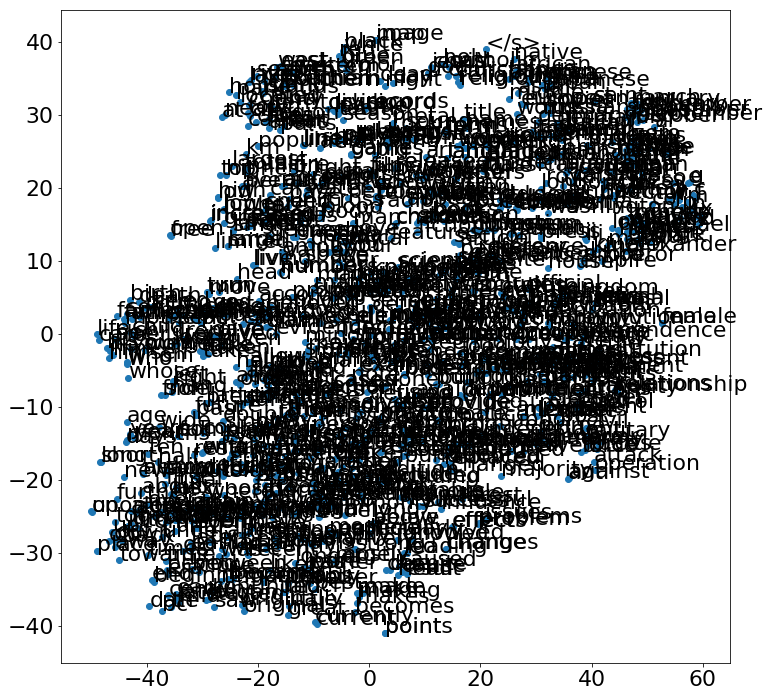

In [6]:
visualize()

Get topK / analogies


In [7]:

def topK(w, k):
    
    # extract the word vector for word w
    idx = vocab.index(w)
    vec = wv[idx, :]
    
    # compute similarity of w with all words in the vocabulary
    sim = wv.dot(vec)
    # sort similarities by descending order
    sort_sim = (sim.argsort())[::-1]

    # choose topK
    best = sort_sim[:(k+1)]
    
    return [str(vocab[i]) for i in best if i!=idx]

    
def analogy(w1, w2, w3):
    # extract the word vectors
    i1 = vocab.index(w1)
    i2 = vocab.index(w2)
    i3 = vocab.index(w3)
    vec1 = wv[i1, :]
    vec2 = wv[i2, :]
    vec3 = wv[i3, :]
    
    # compute the expected vector
    expected = vec1 - vec2 + vec3
    
    # compute similarity of the expected vector with all word in the vocabulary
    sim = wv.dot(expected)
    # sort similarities by descending order
    sort_sim = (sim.argsort())[::-1]
    
    # choose the closest word that does not apper in the analogy query
    for i in sort_sim:
        if i not in [i1, i2, i3]:
            return str(vocab[i])
        


In [8]:
topK("dog", 15)

['dogs',
 'mastiff',
 'borzoi',
 'hounds',
 'terrier',
 'hound',
 'spaniel',
 'badger',
 'bonzo',
 'spitz',
 'puppy',
 'husky',
 'sleds',
 'inu',
 'bolonka']

In [9]:
topK("terrier", 15)

['spaniel',
 'mastiff',
 'coonhound',
 'bolonka',
 'cur',
 'pinscher',
 'sheepdog',
 'retriever',
 'foxhound',
 'bulldog',
 'schnauzer',
 'wirehaired',
 'apso',
 'treeing',
 'collie']

In [10]:
topK("walk", 15)

['ride',
 'walked',
 'walking',
 'climb',
 'walks',
 'fly',
 'climbs',
 'sit',
 'stand',
 'shoot',
 'chasing',
 'snipe',
 'go',
 'blvd',
 'canter']

Analogies - usually works well, but not always. Following are some examples (note that training the model is not deterministic, so results might slightly change)


In [11]:
analogy("king", "man", "woman") 

'queen'

In [12]:
analogy("mice", "mouse", "door")

'doors'

In [13]:
analogy("saying", "walking", "walked")

'said'

In [14]:
analogy("smaller", "small", "big")

'bigger'

In [15]:
analogy("boy", "man", "woman")

'girl'

In [16]:
analogy("reading", "walking", "walked")

'read'

In [17]:
analogy("mice", "mouse", "tour")

'appice'

Use glove pre-trained embeddings for the next example

In [18]:
%cd ..
!mkdir glove
%cd glove
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

/home/nlp/gonenhi/wids/version_to_publish
/home/nlp/gonenhi/wids/version_to_publish/glove
--2018-03-06 13:10:53--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2018-03-06 13:10:54--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

100%[======================================>] 862,182,613 11.5MB/s   in 1m 41s 

2018-03-06 13:12:35 (8.15 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.

In [19]:
filename = "glove.6B.300d.txt"
vocab, wv = load_embeddings()

Classification using word embeddings

In [20]:
from sklearn import svm
import random
random.seed(10)

# a short list of positive examples
prof = ['teacher','carpenter', 'fireman', 'doctor', 'cook', 'nurse', 'secretary', 'manger','minister', 'artist', 'painter',\
        'farmer', 'driver', 'waiter', 'lawyer', 'accountant', 'actor', 'butcher', 'baker','dentist','fisherman','judge']

# choose random negative examples
others = [random.choice(vocab) for i in range(200)]

# train a classification model

X = [wv[vocab.index(w), :] for w in prof + others]
y = [1]*len(prof) + [0]*len(others)

clf = svm.SVC()
clf.fit(X, y)  

# predict 0/1 for a sample of negative/positive words

pred = ['boy', 'apple', 'mouse', 'sphere', 'shirt','sky','camera','pen', 'bee', 'move','talking', 'dream']
print clf.predict([wv[vocab.index(w), :] for w in pred])

pred = ['lifeguard', 'engineer', 'carpenter','tailor','translator', 'mechanic', 'politician','librarian']
print clf.predict([wv[vocab.index(w), :] for w in pred])

# print words that are positive (partial list)
for w in vocab[10000:50000]:
    if clf.predict([wv[vocab.index(w), :]]):
        print w

        

[1 0 0 0 0 0 0 0 0 0 0 0]
[0 1 1 0 1 1 1 0]
psychologist
lecturer
playwright
27-year
translator
28-year
sailor
cricketer
salesman
murdering
sculptor
screenwriter
counselor
murderer
35-year
butcher
inventor
presenter
accountant
maid
preacher
gentleman
technician
mechanic
educator
apprentice
fisherman
solicitor
firefighter
mathematician
dentist
chemist
housewife
waitress
waiter
schoolteacher
bartender
pharmacist
barrister
electrician
trainee
